In [12]:
# Download the dataset with curl and save locally as sign-language-img.zip
# Use -L to follow redirects and -k to ignore certificate verification if necessary
!curl -L -k https://storage.googleapis.com/platzi-tf2/sign-language-img.zip -o sign-language-img.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 23.1M    0 15145    0     0  21535      0  0:18:46 --:--:--  0:18:46 21543
 63 23.1M   63 14.7M    0     0   9.8M      0  0:00:02  0:00:01  0:00:01  9.8M
100 23.1M  100 23.1M    0     0  10.9M      0  0:00:02  0:00:02 --:--:-- 10.9M


In [13]:
import os
import zipfile

local_zip = "sign-language-img.zip"
# ensure the zip file exists before attempting to open
if not os.path.exists(local_zip):
    raise FileNotFoundError(f"{local_zip} not found. Please run the download cell first and verify the file was saved correctly.")

with zipfile.ZipFile(local_zip, 'r') as zip_ref:
    zip_ref.extractall('sign-language-img')

print('Extraction complete: sign-language-img/')

Extraction complete: sign-language-img/


In [45]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import string
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [46]:
train_dir = "sign-language-img/Train"
test_dir = "sign-language-img/Test"

In [47]:
# Use validation_split on the training generator (Train directory)
# Add safe data augmentation to improve generalization (avoid horizontal_flip for sign language)
train_datagen = ImageDataGenerator(
    rescale=1/255,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.05,
    horizontal_flip=False
)
# Test generator should only rescale and use the Test directory for final evaluation
test_datagen = ImageDataGenerator(rescale=1/255)

In [48]:
# Create train/validation generators from the Train directory using validation_split
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(28, 28),
    batch_size=128,
    class_mode="categorical",
    color_mode="grayscale",
    subset="training"
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(28, 28),
    batch_size=128,
    class_mode="categorical",
    color_mode="grayscale",
    subset="validation"
)

# Test generator uses the Test directory (no subset)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(28, 28),
    batch_size=128,
    class_mode="categorical",
    color_mode="grayscale"
)

Found 21974 images belonging to 24 classes.
Found 5481 images belonging to 24 classes.
Found 5481 images belonging to 24 classes.
Found 7172 images belonging to 24 classes.
Found 7172 images belonging to 24 classes.


In [49]:
classes = [char for char in string.ascii_uppercase if char != "J" if char != "Z"]

In [50]:
classes

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y']

In [51]:
def plotImages(images_arr):
  fig, axes = plt.subplots(1, 5, figsize = (10, 10))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img[:,:,0])
    ax.axis("off")
  plt.tight_layout()
  plt.show()

In [52]:
# Quick integrity check: find corrupted or non-image files before sampling or training
from PIL import Image, UnidentifiedImageError
import os, shutil

# get filepaths from the generator (relative paths)
filepaths = getattr(train_generator, 'filepaths', None) or getattr(train_generator, 'filenames', [])
base_dir = getattr(train_generator, 'directory', '.')
bad = []
for rel in filepaths:
    path = rel if os.path.isabs(rel) else os.path.join(base_dir, rel)
    try:
        if os.path.isdir(path):
            raise IsADirectoryError('is a directory')
        if os.path.getsize(path) == 0:
            raise ValueError('zero-byte file')
        with open(path, 'rb') as f:
            img = Image.open(f)
            img.verify()
    except Exception as e:
        bad.append((path, type(e).__name__, str(e)))

print('Checked', len(filepaths), 'files. Bad found:', len(bad))
if bad:
    os.makedirs('bad_images', exist_ok=True)
    for p, _, _ in bad:
        try:
            shutil.move(p, os.path.join('bad_images', os.path.basename(p)))
        except Exception as e:
            print('Could not move', p, e)
    print('Moved bad files to ./bad_images. Recreate generators after cleaning.')
    # Recreate generators to refresh file lists after cleaning
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(28,28),
        batch_size=128,
        class_mode="categorical",
        color_mode="grayscale",
        subset="training"
    )
    validation_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(28,28),
        batch_size=128,
        class_mode="categorical",
        color_mode="grayscale",
        subset="validation"
    )
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(28,28),
        batch_size=128,
        class_mode="categorical",
        color_mode="grayscale"
    )

Checked 21974 files. Bad found: 21974
Could not move sign-language-img/Train\sign-language-img/Train\A\14928_A.jpg [WinError 3] El sistema no puede encontrar la ruta especificada
Could not move sign-language-img/Train\sign-language-img/Train\A\14947_A.jpg [WinError 3] El sistema no puede encontrar la ruta especificada
Could not move sign-language-img/Train\sign-language-img/Train\A\14967_A.jpg [WinError 3] El sistema no puede encontrar la ruta especificada
Could not move sign-language-img/Train\sign-language-img/Train\A\14970_A.jpg [WinError 3] El sistema no puede encontrar la ruta especificada
Could not move sign-language-img/Train\sign-language-img/Train\A\14982_A.jpg [WinError 3] El sistema no puede encontrar la ruta especificada
Could not move sign-language-img/Train\sign-language-img/Train\A\15001_A.jpg [WinError 3] El sistema no puede encontrar la ruta especificada
Could not move sign-language-img/Train\sign-language-img/Train\A\15025_A.jpg [WinError 3] El sistema no puede encont

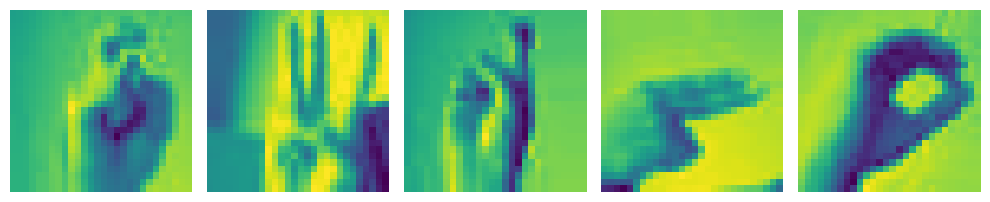

In [54]:
# sample and show images (after integrity check has run)
sample_training_images, _ = next(train_generator)
plotImages(sample_training_images[:5])

In [55]:
model_base = tf.keras.models.Sequential([
              tf.keras.layers.Flatten(input_shape= (28, 28, 1)),
              tf.keras.layers.Dense(256, activation = "relu"),
              tf.keras.layers.Dense(128, activation = "relu"),
              tf.keras.layers.Dense(len(classes), activation = "softmax")
])

d:\david\learning_platzi\machine_learning\redes_neuronales_tensorflow\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [56]:
model_base.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_6 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 24)             │         3,096 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 236,952 (925.59 KB)

 Trainable params: 236,952 (925.59 KB)

 Non-trainable params: 0 (0.00 B)

In [57]:
model_base.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ['accuracy'])


history = model_base.fit(
    train_generator, 
    epochs= 10, 
    validation_data = validation_generator
)

Epoch 1/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - accuracy: 0.1813 - loss: 2.7993 - val_accuracy: 0.2720 - val_loss: 2.4165
Epoch 2/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - accuracy: 0.1813 - loss: 2.7993 - val_accuracy: 0.2720 - val_loss: 2.4165
Epoch 2/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.3205 - loss: 2.2196 - val_accuracy: 0.3592 - val_loss: 2.0814
Epoch 3/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.3205 - loss: 2.2196 - val_accuracy: 0.3592 - val_loss: 2.0814
Epoch 3/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.3763 - loss: 1.9968 - val_accuracy: 0.3866 - val_loss: 1.9376
Epoch 4/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.3763 - loss: 1.9968 - val_accuracy: 0.3866 - val_loss: 1.9376
Epoch 4/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.4220 - loss: 1.8327 - val_accuracy: 0.4351 - val_loss: 1.7841
Epoch 5/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.4220 - loss: 1.8327 - 

In [58]:
results = model_base.evaluate(test_generator)

57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.6557 - loss: 0.9829
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.6557 - loss: 0.9829


In [59]:
def visualizacion_resultados(history):
  # determine number of epochs from history arrays so function works for any training length
  n = len(history.history.get('loss', []))
  epochs = list(range(1, n+1))
  fig, ax = plt.subplots(1,2, figsize=(16,9))
  train_acc = history.history.get('accuracy', [])
  train_loss = history.history.get('loss', [])
  val_acc = history.history.get('val_accuracy', [])
  val_loss = history.history.get('val_loss', [])

  ax[0].plot(epochs, train_acc, 'go-', label ='Entrenamiento accuracy')
  ax[0].plot(epochs, val_acc, 'ro-', label= 'Validacion accuracy')
  ax[0].set_title('Entrenamiento & validación accuracy')
  ax[0].legend()
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Accuracy')

  ax[1].plot(epochs, train_loss, 'go-', label ='Entrenamiento Loss')
  ax[1].plot(epochs, val_loss, 'ro-', label= 'Validacion Loss')
  ax[1].set_title('Entrenamiento & validación Loss')
  ax[1].legend()
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Loss')

  plt.show()

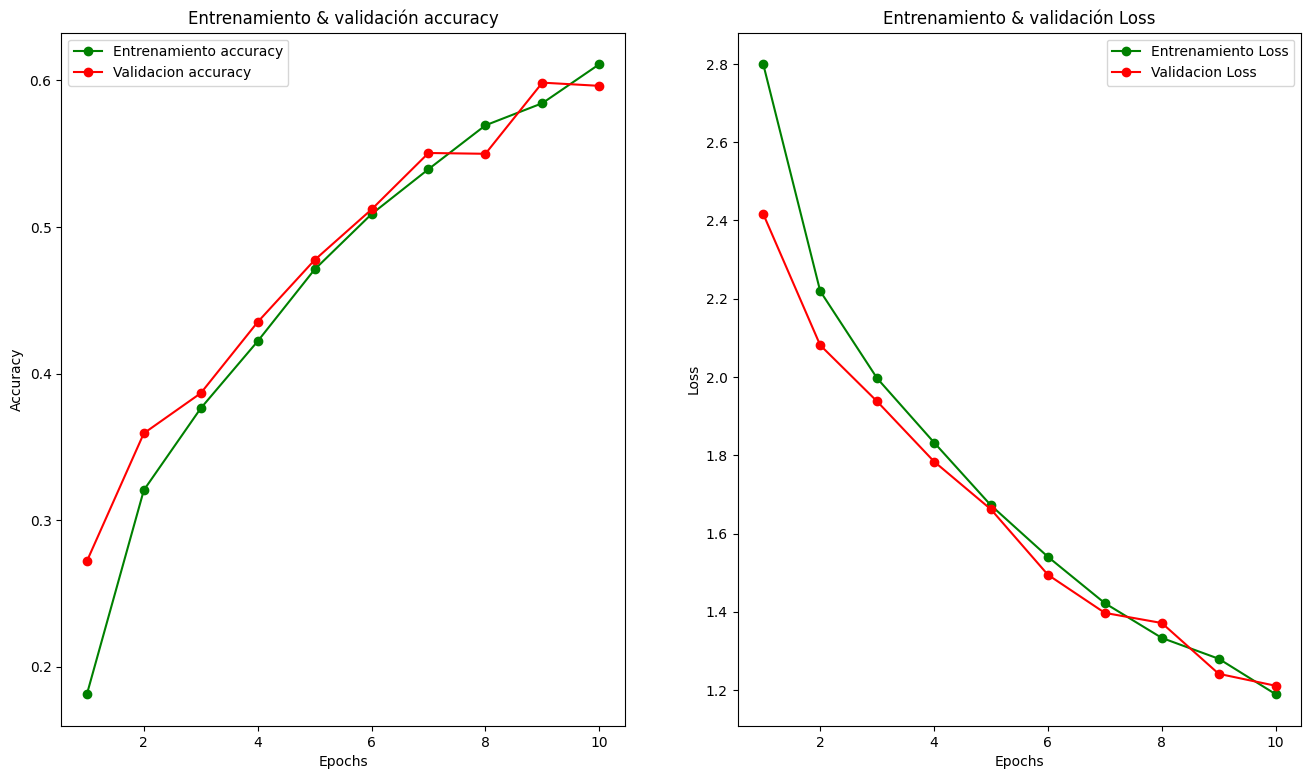

In [60]:
visualizacion_resultados(history)

In [61]:
from tensorflow.keras import regularizers

In [62]:
model_optimizer = tf.keras.models.Sequential([
              tf.keras.layers.Flatten(input_shape= (28, 28, 1)),
              tf.keras.layers.Dense(256, kernel_regularizer = regularizers.l2(1e-5), activation = "relu"),
              tf.keras.layers.Dropout(0.2),
              tf.keras.layers.Dense(128, kernel_regularizer= regularizers.l2(1e-5),activation = "relu"),
              tf.keras.layers.Dropout(0.2),
              tf.keras.layers.Dense(len(classes), activation = "softmax")
])

model_optimizer.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_7 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 24)             │         3,096 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 236,952 (925.59 KB)

 Trainable params: 236,952 (925.59 KB)

 Non-trainable params: 0 (0.00 B)

In [63]:
model_optimizer.compile(optimizer= "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

history_optimizer = model_optimizer.fit(
    train_generator,
    epochs = 20,
    validation_data = validation_generator,
    callbacks = common_callbacks
)

Epoch 1/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.1277 - loss: 2.9308 - val_accuracy: 0.2500 - val_loss: 2.4746
Epoch 2/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.1277 - loss: 2.9308 - val_accuracy: 0.2500 - val_loss: 2.4746
Epoch 2/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.2427 - loss: 2.4174 - val_accuracy: 0.2968 - val_loss: 2.1940
Epoch 3/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.2427 - loss: 2.4174 - val_accuracy: 0.2968 - val_loss: 2.1940
Epoch 3/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - accuracy: 0.2951 - loss: 2.2215 - val_accuracy: 0.3465 - val_loss: 2.0335
Epoch 4/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - accuracy: 0.2951 - loss: 2.2215 - val_accuracy: 0.3465 - val_loss: 2.0335
Epoch 4/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.3374 - loss: 2.0680 - val_accuracy: 0.4224 - val_loss: 1.8459
172/172 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.3374 - loss: 2.0680 - val_accurac

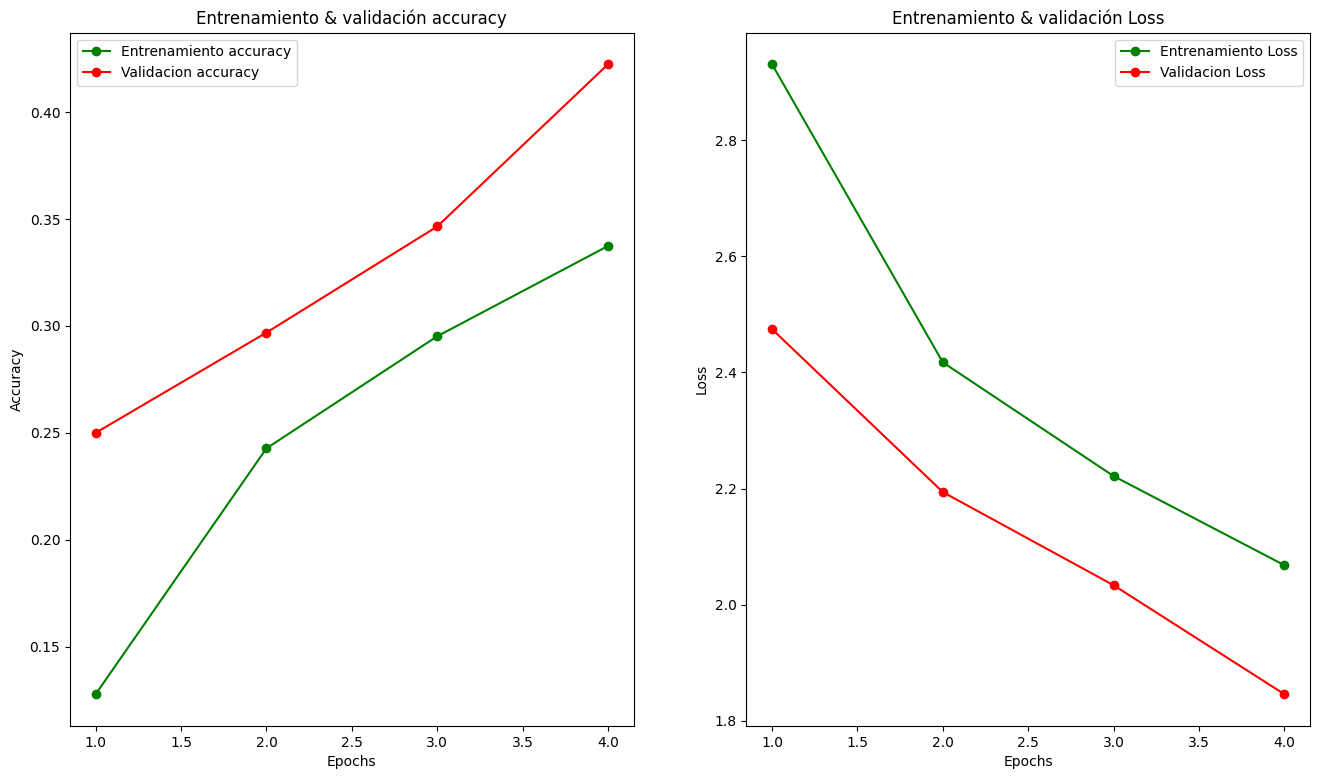

In [64]:
visualizacion_resultados(history_optimizer)

In [65]:
model_convolutional = tf.keras.models.Sequential([
              tf.keras.layers.Conv2D(75, (3,3), activation = "relu", input_shape= (28, 28, 1)),
              tf.keras.layers.MaxPool2D((2,2)),
              tf.keras.layers.Flatten(),
              tf.keras.layers.Dense(256, kernel_regularizer = regularizers.l2(1e-5), activation = "relu"),
              tf.keras.layers.Dropout(0.2),
              tf.keras.layers.Dense(128, kernel_regularizer= regularizers.l2(1e-5),activation = "relu"),
              tf.keras.layers.Dropout(0.2),
              tf.keras.layers.Dense(len(classes), activation = "softmax")
])

model_convolutional.summary()

model_convolutional.compile(optimizer= "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

history_convolutional = model_convolutional.fit(
    train_generator,
    epochs = 20,
    validation_data = validation_generator,
    callbacks = common_callbacks
)

d:\david\learning_platzi\machine_learning\redes_neuronales_tensorflow\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 26, 26, 75)     │           750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 13, 13, 75)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 12675)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 256)            │     3,245,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 24)             │         3,096 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,281,798 (12.52 MB)

 Trainable params: 3,281,798 (12.52 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 17s 95ms/step - accuracy: 0.1839 - loss: 2.6877 - val_accuracy: 0.4200 - val_loss: 1.8962
Epoch 2/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 17s 95ms/step - accuracy: 0.1839 - loss: 2.6877 - val_accuracy: 0.4200 - val_loss: 1.8962
Epoch 2/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 16s 94ms/step - accuracy: 0.4476 - loss: 1.7053 - val_accuracy: 0.6176 - val_loss: 1.2550
Epoch 3/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 16s 94ms/step - accuracy: 0.4476 - loss: 1.7053 - val_accuracy: 0.6176 - val_loss: 1.2550
Epoch 3/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 17s 96ms/step - accuracy: 0.5910 - loss: 1.2461 - val_accuracy: 0.7278 - val_loss: 0.8946
Epoch 4/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 17s 96ms/step - accuracy: 0.5910 - loss: 1.2461 - val_accuracy: 0.7278 - val_loss: 0.8946
Epoch 4/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 16s 94ms/step - accuracy: 0.6651 - loss: 1.0003 - val_accuracy: 0.7794 - val_loss: 0.7176
172/172 ━━━━━━━━━━━━━━━━━━━━ 16s 94ms/step - accuracy: 0.6651 - loss: 1.0003 - val_accurac

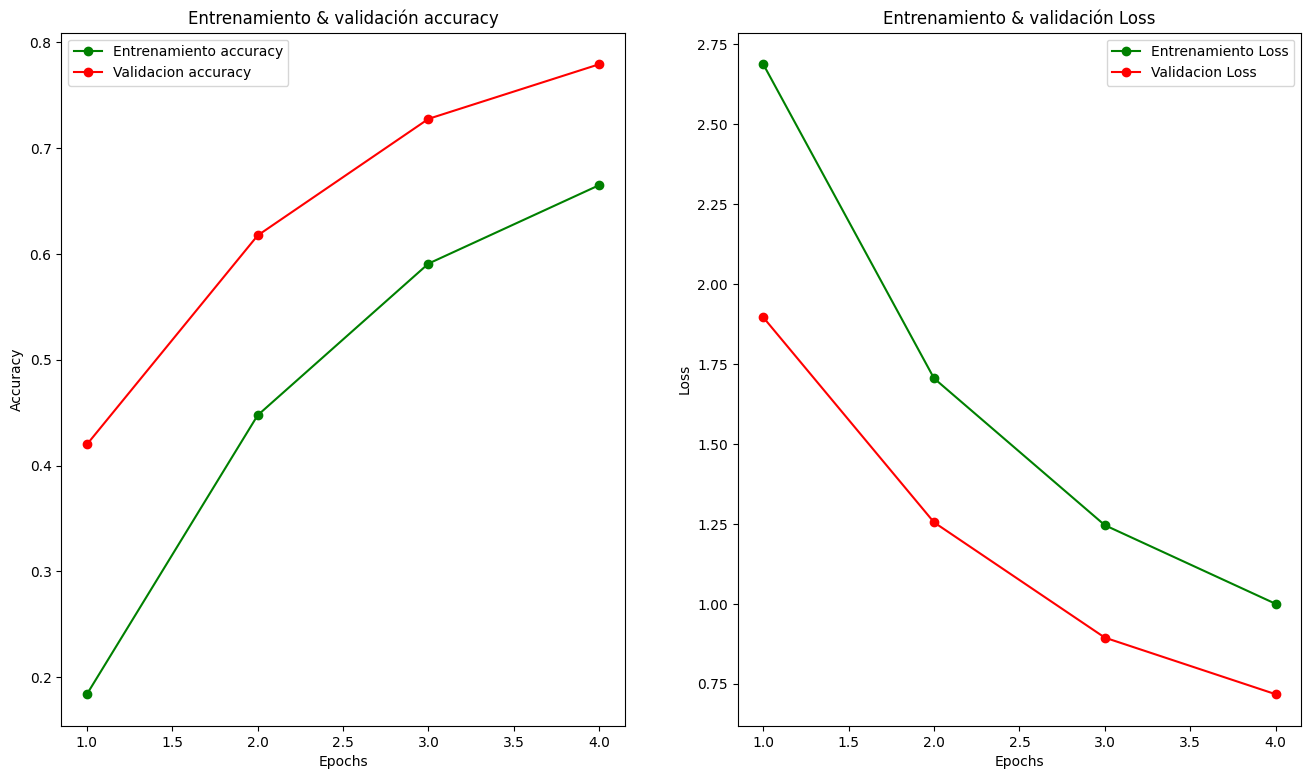

In [66]:
visualizacion_resultados(history_convolutional)

In [67]:
model_callback = tf.keras.models.Sequential([
              tf.keras.layers.Conv2D(75, (3,3), activation = "relu", input_shape= (28, 28, 1)),
              tf.keras.layers.MaxPool2D((2,2)),
              tf.keras.layers.Flatten(),
              tf.keras.layers.Dense(256, kernel_regularizer = regularizers.l2(1e-5), activation = "relu"),
              tf.keras.layers.Dropout(0.2),
              tf.keras.layers.Dense(128, kernel_regularizer= regularizers.l2(1e-5),activation = "relu"),
              tf.keras.layers.Dropout(0.2),
              tf.keras.layers.Dense(len(classes), activation = "softmax")
])

model_callback.summary()

model_callback.compile(optimizer= "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 26, 26, 75)     │           750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 13, 13, 75)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 12675)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │     3,245,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 24)             │         3,096 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,281,798 (12.52 MB)

 Trainable params: 3,281,798 (12.52 MB)

 Non-trainable params: 0 (0.00 B)

In [68]:
from tensorflow.keras.callbacks import Callback

class TrainingCallback(Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if logs.get("accuracy") > 0.95:
      print("Lo logramos, nuestro modelo llego a 95%, detenemos el entrenamiento")
      self.model.stop_training = True

In [69]:
# Common callbacks: EarlyStopping + ModelCheckpoint to prevent overfitting and save best weights
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)
mc = ModelCheckpoint("best_model.h5", monitor="val_loss", save_best_only=True)
common_callbacks = [es, mc]

In [70]:
callback = TrainingCallback()

# combine custom training callback with common callbacks
callbacks = [callback] + common_callbacks

history_callback = model_callback.fit(
    train_generator,
    epochs = 20,
    callbacks = callbacks,
    validation_data = validation_generator
)

Epoch 1/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.1280 - loss: 2.9527

172/172 ━━━━━━━━━━━━━━━━━━━━ 18s 98ms/step - accuracy: 0.2261 - loss: 2.5631 - val_accuracy: 0.4990 - val_loss: 1.6701
Epoch 2/20
Epoch 2/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.4558 - loss: 1.6828

172/172 ━━━━━━━━━━━━━━━━━━━━ 16s 93ms/step - accuracy: 0.5012 - loss: 1.5321 - val_accuracy: 0.6554 - val_loss: 1.0915
Epoch 3/20
Epoch 3/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.5897 - loss: 1.2338

172/172 ━━━━━━━━━━━━━━━━━━━━ 16s 95ms/step - accuracy: 0.6086 - loss: 1.1761 - val_accuracy: 0.7386 - val_loss: 0.8562
Epoch 4/20
Epoch 4/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.6654 - loss: 0.9975

172/172 ━━━━━━━━━━━━━━━━━━━━ 17s 99ms/step - accuracy: 0.6804 - loss: 0.9550 - val_accuracy: 0.7931 - val_loss: 0.6929
Epoch 5/20
Epoch 5/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.7182 - loss: 0.8354

172/172 ━━━━━━━━━━━━━━━━━━━━ 17s 98ms/step - accuracy: 0.7293 - loss: 0.8090 - val_accuracy: 0.8247 - val_loss: 0.5798
Epoch 6/20
Epoch 6/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.7631 - loss: 0.7202

172/172 ━━━━━━━━━━━━━━━━━━━━ 17s 96ms/step - accuracy: 0.7711 - loss: 0.7029 - val_accuracy: 0.8458 - val_loss: 0.5008
Epoch 7/20
Epoch 7/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.7851 - loss: 0.6514

172/172 ━━━━━━━━━━━━━━━━━━━━ 17s 99ms/step - accuracy: 0.7913 - loss: 0.6269 - val_accuracy: 0.8783 - val_loss: 0.4308
Epoch 8/20
Epoch 8/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.8123 - loss: 0.5826

172/172 ━━━━━━━━━━━━━━━━━━━━ 17s 97ms/step - accuracy: 0.8150 - loss: 0.5763 - val_accuracy: 0.8982 - val_loss: 0.3674
Epoch 9/20
Epoch 9/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.8312 - loss: 0.5296

172/172 ━━━━━━━━━━━━━━━━━━━━ 17s 97ms/step - accuracy: 0.8338 - loss: 0.5206 - val_accuracy: 0.9104 - val_loss: 0.3345
Epoch 10/20
Epoch 10/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8519 - loss: 0.4739

172/172 ━━━━━━━━━━━━━━━━━━━━ 17s 97ms/step - accuracy: 0.8524 - loss: 0.4759 - val_accuracy: 0.9268 - val_loss: 0.2898
Epoch 11/20
Epoch 11/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.8546 - loss: 0.4633

172/172 ━━━━━━━━━━━━━━━━━━━━ 17s 96ms/step - accuracy: 0.8586 - loss: 0.4534 - val_accuracy: 0.9327 - val_loss: 0.2625
Epoch 12/20
Epoch 12/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.8663 - loss: 0.4248

172/172 ━━━━━━━━━━━━━━━━━━━━ 17s 97ms/step - accuracy: 0.8704 - loss: 0.4194 - val_accuracy: 0.9407 - val_loss: 0.2370
Epoch 13/20
Epoch 13/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 17s 96ms/step - accuracy: 0.8809 - loss: 0.3991 - val_accuracy: 0.9378 - val_loss: 0.2432
Epoch 14/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 17s 96ms/step - accuracy: 0.8809 - loss: 0.3991 - val_accuracy: 0.9378 - val_loss: 0.2432
Epoch 14/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8813 - loss: 0.3882

172/172 ━━━━━━━━━━━━━━━━━━━━ 17s 96ms/step - accuracy: 0.8836 - loss: 0.3824 - val_accuracy: 0.9548 - val_loss: 0.2029
Epoch 15/20
Epoch 15/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 16s 95ms/step - accuracy: 0.8912 - loss: 0.3682 - val_accuracy: 0.9577 - val_loss: 0.2044
Epoch 16/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 16s 95ms/step - accuracy: 0.8912 - loss: 0.3682 - val_accuracy: 0.9577 - val_loss: 0.2044
Epoch 16/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.8957 - loss: 0.3514

172/172 ━━━━━━━━━━━━━━━━━━━━ 17s 96ms/step - accuracy: 0.9000 - loss: 0.3461 - val_accuracy: 0.9566 - val_loss: 0.1975
Epoch 17/20
Epoch 17/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9050 - loss: 0.3264

172/172 ━━━━━━━━━━━━━━━━━━━━ 17s 98ms/step - accuracy: 0.9043 - loss: 0.3293 - val_accuracy: 0.9560 - val_loss: 0.1939
Epoch 18/20
Epoch 18/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9004 - loss: 0.3335

172/172 ━━━━━━━━━━━━━━━━━━━━ 17s 96ms/step - accuracy: 0.9025 - loss: 0.3311 - val_accuracy: 0.9644 - val_loss: 0.1723
Epoch 19/20
Epoch 19/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9131 - loss: 0.3043

172/172 ━━━━━━━━━━━━━━━━━━━━ 17s 97ms/step - accuracy: 0.9090 - loss: 0.3157 - val_accuracy: 0.9652 - val_loss: 0.1707
Epoch 20/20
Epoch 20/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9092 - loss: 0.3138

172/172 ━━━━━━━━━━━━━━━━━━━━ 17s 97ms/step - accuracy: 0.9104 - loss: 0.3133 - val_accuracy: 0.9712 - val_loss: 0.1479


In [71]:
# Evaluate the convolutional model on the test set
results_conv = model_convolutional.evaluate(test_generator)
print('Test loss:', results_conv[0])
print('Test accuracy:', results_conv[1])

57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5286 - loss: 1.5851
Test loss: 1.5851351022720337
Test accuracy: 0.5285834074020386
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5286 - loss: 1.5851
Test loss: 1.5851351022720337
Test accuracy: 0.5285834074020386


In [73]:
def get_model():
    model = tf.keras.models.Sequential([
              tf.keras.layers.Conv2D(75, (3,3), activation = "relu", input_shape= (28, 28, 1)),
              tf.keras.layers.MaxPool2D((2,2)),
              tf.keras.layers.Flatten(),
              tf.keras.layers.Dense(256, kernel_regularizer = regularizers.l2(1e-5), activation = "relu"),
              tf.keras.layers.Dropout(0.2),
              tf.keras.layers.Dense(128, kernel_regularizer= regularizers.l2(1e-5),activation = "relu"),
              tf.keras.layers.Dropout(0.2),
              tf.keras.layers.Dense(len(classes), activation = "softmax")
    ])
    return model

model_early = get_model()
model_early.summary()
model_early.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

d:\david\learning_platzi\machine_learning\redes_neuronales_tensorflow\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 26, 26, 75)     │           750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 13, 13, 75)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 12675)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 256)            │     3,245,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 24)             │         3,096 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,281,798 (12.52 MB)

 Trainable params: 3,281,798 (12.52 MB)

 Non-trainable params: 0 (0.00 B)

In [74]:
callback_early = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=3, mode = "auto")

In [75]:
history_early = model_early.fit(
    train_generator,
    epochs = 20,
    callbacks = [callback_early],
    validation_data = validation_generator
)

Epoch 1/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 27s 151ms/step - accuracy: 0.2283 - loss: 2.5561 - val_accuracy: 0.5140 - val_loss: 1.6772
Epoch 2/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 27s 151ms/step - accuracy: 0.2283 - loss: 2.5561 - val_accuracy: 0.5140 - val_loss: 1.6772
Epoch 2/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 16s 94ms/step - accuracy: 0.5185 - loss: 1.4884 - val_accuracy: 0.6789 - val_loss: 1.0817
Epoch 3/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 16s 94ms/step - accuracy: 0.5185 - loss: 1.4884 - val_accuracy: 0.6789 - val_loss: 1.0817
Epoch 3/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 16s 95ms/step - accuracy: 0.6418 - loss: 1.0871 - val_accuracy: 0.7688 - val_loss: 0.7903
Epoch 4/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 16s 95ms/step - accuracy: 0.6418 - loss: 1.0871 - val_accuracy: 0.7688 - val_loss: 0.7903
Epoch 4/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 17s 96ms/step - accuracy: 0.7102 - loss: 0.8814 - val_accuracy: 0.8185 - val_loss: 0.6225
Epoch 5/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 17s 96ms/step - accuracy: 0.7102 - loss: 0.8814 

In [76]:
%pip install -q -U keras-tuner
import kerastuner as kt
from tensorflow import keras

Note: you may need to restart the kernel to use updated packages.


C:\Users\david\AppData\Local\Temp\ipykernel_18468\3551396356.py:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [77]:
def constructor_modelos(hp):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv2D(75, (3,3), activation= "relu", input_shape = (28, 28, 1)))
  model.add(tf.keras.layers.MaxPool2D((2,2)))
  model.add(tf.keras.layers.Flatten())

  hp_units = hp.Int("units", min_value = 32, max_value = 512, step = 32)
  model.add(tf.keras.layers.Dense(units=hp_units,activation = "relu", kernel_regularizer= regularizers.l2(1e-5)))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(128,activation = "relu", kernel_regularizer= regularizers.l2(1e-5)))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(len(classes), activation = "softmax"))

  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])

  model.compile(optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate),loss = "categorical_crossentropy", metrics = ["accuracy"])

  return model